# Publishing blog posts directly from Notebooks

## Goals:  
- Publish your first blog post.  
- Create a full, proper python library for the custom Sentiment Analysis pipeline from last time.   

# Publishing directly from a Notebook  

> Reference: [blogging with nbdev.](https://nbdev.fast.ai/tutorials/blogging.html)

`nbdev` leverages an amazing tool called [Quarto](https://quarto.org/).

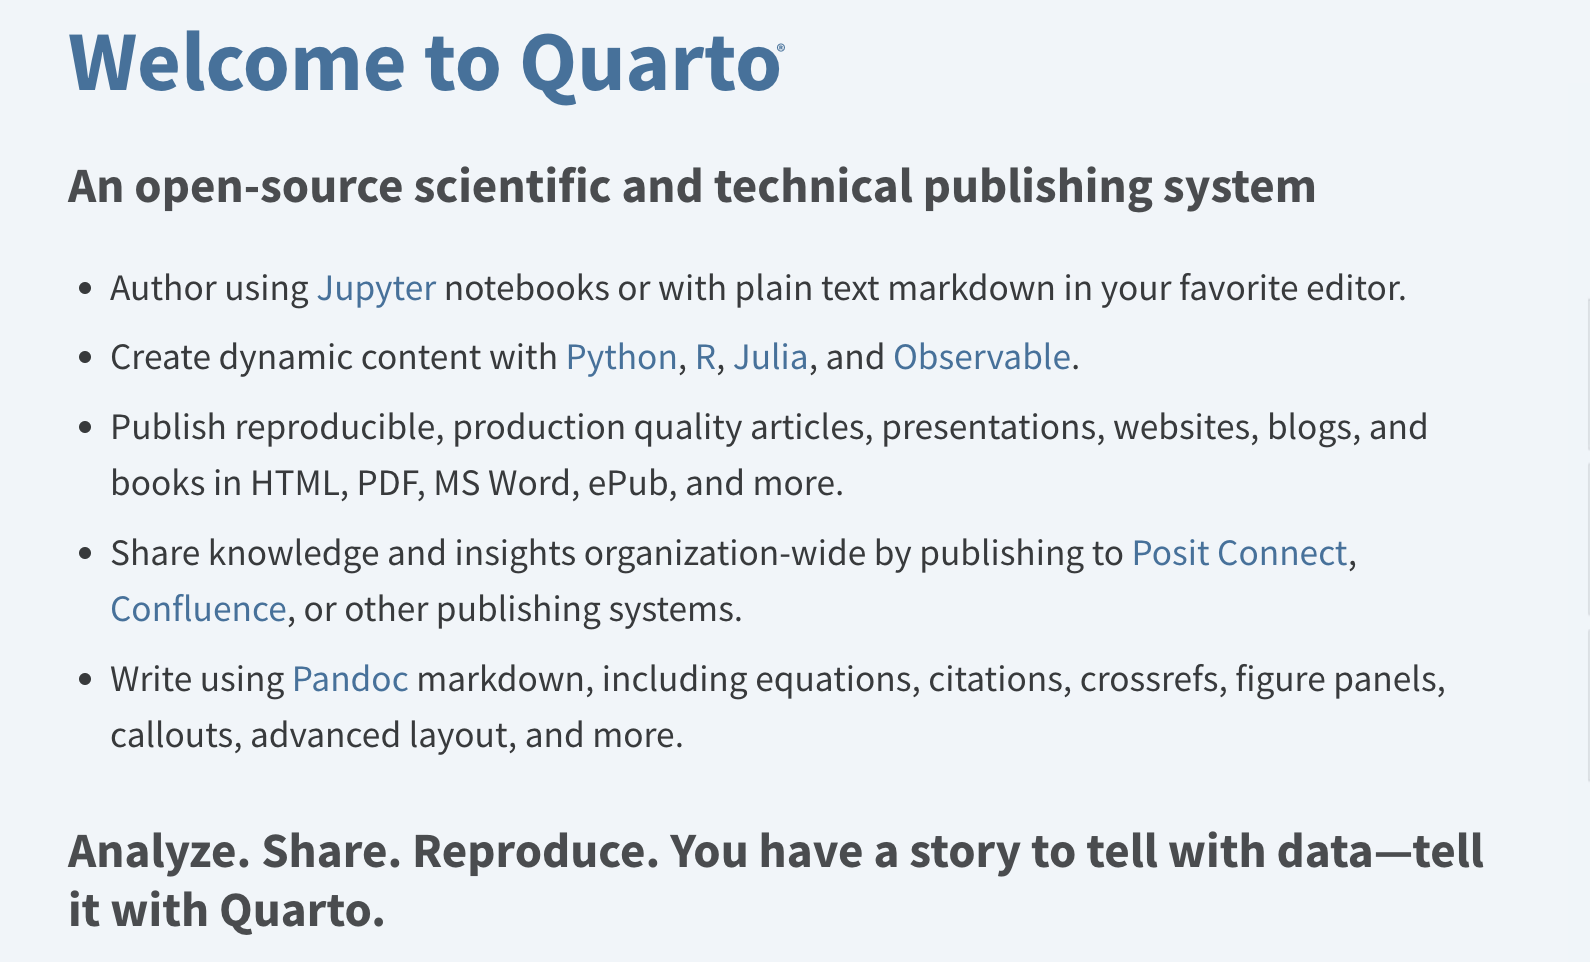

Here we take a closer look at the `nbdev` library. `nbdev` is a powerful tool based on two key ideas:  
- Literate programming. 
- Exploratory programming.  


In Literate Programming, descriptions (documentation) are woven directly into a project's source code.  
This is opposite of how most codebases are set up, where documentation exists as a separate set of files.  

How is this different from parsing source code and comments into documentation? In Literate Programming the code, tests, and documentation are all first-class citizens. And with `nbdev`, the Notebook is the single source of truth for all of these. Think about what this truly means, and just how much overhead work it removes.   

Instead of having to independently manage code, docs, and tests, everything can be done in Notebooks. If the notebook runs, you know your code will run. And you can directly document and test your code in the notebook as you develop.    

Exploratory programming is, as the name suggests, an open-ended approach to coding when exploring unknown domains or areas. Folks often use it at the start of a project, when the requirements or scope are not yet flushed out.  

Try things out, figure out how they work, what they do. Poke around. Explore. Follow that curiosity. Have fun! Can always restart the Notebook, no fear around trying things - very little to no downside.  

`nbdev` combines these two ideas. We can then mix and match them in different doses as needed.  

This notebook will turn our previous, first runs into a proper python library.  
It will have documentation and tests directly in the notebook.  


In [ ]:
#| default_exp lesson_2.mock_pipeline

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| export  
from transformers import AutoConfig
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

In [ ]:
#| export  

class SentimentPipeline:
    def __init__(self, model_name):
        """
        Sentiment Analysis pipeline.
        """
        self.model_name = model_name
        self.config = AutoConfig.from_pretrained(self.model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.model = AutoModelForSequenceClassification.from_pretrained(self.model_name)


    def preprocess(self, text: str):
        """
        Sends `text` through the LLM's tokenizer.  
        The tokenizers turns words and characters into special inputs for the LLM.
        """
        tokenized_inputs = self.tokenizer(text, return_tensors='pt')
        return tokenized_inputs
    

    def forward(self, text: str):
        """
        First we preprocess the `text` into tokens.
        Then we send the `token_inputs` to the model.
        """
        token_inputs = self.preprocess(text)
        outputs = self.model(**token_inputs)
        return outputs
    

    def process_outputs(self, outs):
        """
        Here is where HuggingFace does the most for us via `pipeline`.  
        """
        # grab the raw "scores" that from the model for Positive and Negative labels
        logits = outs.logits

        # find the strongest label score, aka the model's decision
        pred_idx = logits.argmax(1).item()

        # use the `config` object to find the class label
        pred_label = self.config.id2label[pred_idx]  

        # calculate the human-readable number for the score
        pred_score = logits.softmax(-1)[:, pred_idx].item()

        return {
            'label': pred_label,
            'score': pred_score, 
        }
    
    def __call__(self, text: str):
        model_outs = self.forward(text)
        preds = self.process_outputs(model_outs)
        return preds
    
    def __repr__(self):
        return f"SentimentAnalysis_{self.model_name}"

